# Using `IN_LEAGUE_NEXT` as our response variable

In this notebook we consider if we can predict `IN_LEAGUE_NEXT`, whether a given player will play _at any point_ (at hence appear in the stats data) during the next season.

In [54]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

## Load/inspect the data

- Load the data
- Drop the season with `SEASON_START=2023`, because we don't know yet if a player will play _at any point_ in the 2024 season
- Drop NAN values (mostly players without salary data).

In [55]:
df = pd.read_csv("Data/merged_data/merged_data_collapsed_teams.csv").dropna() #drop NAN rows
df = df[df["SEASON_START"] < 2023]

In [56]:
df.columns

Index(['NAME', 'PLAYER_ID', 'SEASON_START', 'TEAMS_LIST', 'PLAYER_AGE',
       'EXPERIENCE', 'POS', 'GP', 'GS', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M',
       'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST',
       'STL', 'BLK', 'TOV', 'PF', 'PTS', 'PER', 'TS_PERCENT', 'X3P_AR', 'F_TR',
       'ORB_PERCENT', 'DRB_PERCENT', 'TRB_PERCENT', 'AST_PERCENT',
       'STL_PERCENT', 'BLK_PERCENT', 'TOV_PERCENT', 'USG_PERCENT', 'OWS',
       'DWS', 'WS', 'WS_48', 'OBPM', 'DBPM', 'BPM', 'VORP', 'Salary',
       'Percent_team_salary', 'WAIVED_OFF', 'WAIVED_REG', 'WAIVED_POST',
       'RELEASED_OFF', 'RELEASED_REG', 'RELEASED_POST', 'TRADED_OFF',
       'TRADED_REG', 'TRADED_POST', 'WAIVED_NEXT_OFF', 'WAIVED_NEXT_REG',
       'WAIVED_NEXT_POST', 'RELEASED_NEXT_OFF', 'RELEASED_NEXT_REG',
       'RELEASED_NEXT_POST', 'TRADED_NEXT_OFF', 'TRADED_NEXT_REG',
       'TRADED_NEXT_POST', 'WAIVED_NEXT_NEXT_OFF', 'RELEASED_NEXT_NEXT_OFF',
       'TRADED_NEXT_NEXT_OFF', 'WAIVED_NBA_YEAR'

In [57]:
df_com = pd.read_csv("Data/merged_data/common_player_data.csv")

#rename PERSON_ID to PLAYER_ID, DRAFT_NUMBER to OVERALL_PICK (more descriptive)
df_com.rename(columns={"PERSON_ID":"PLAYER_ID", "DRAFT_NUMBER":"OVERALL_PICK"}, inplace=True)

#display a random row
df_com.sample(1)

,PLAYER_ID,FIRST_NAME,LAST_NAME,DISPLAY_FIRST_LAST,DISPLAY_LAST_COMMA_FIRST,DISPLAY_FI_LAST,PLAYER_SLUG,BIRTHDATE,SCHOOL,COUNTRY,LAST_AFFILIATION,HEIGHT,WEIGHT,SEASON_EXP,JERSEY,POSITION,ROSTERSTATUS,GAMES_PLAYED_CURRENT_SEASON_FLAG,TEAM_ID,TEAM_NAME,TEAM_ABBREVIATION,TEAM_CODE,TEAM_CITY,PLAYERCODE,FROM_YEAR,TO_YEAR,DLEAGUE_FLAG,NBA_FLAG,GAMES_PLAYED_FLAG,DRAFT_YEAR,DRAFT_ROUND,OVERALL_PICK,GREATEST_75_FLAG
2861,78161,Scott,Sims,Scott Sims,"Sims, Scott",S. Sims,scott-sims,1955-04-18T00:00:00,Missouri,USA,Missouri/USA,6-1,170.0,1,20,Guard,Inactive,N,1610612759,Spurs,SAS,spurs,San Antonio,HISTADD_scott_sims,1977.0,1977.0,N,Y,Y,1977,5,103,N


In [58]:
#keep only: PLAYER_ID, HEIGHT, WEIGHT, OVERALL_PICK, GREATEST_75_FLAG
df_com_reduced = df_com[["PLAYER_ID", "HEIGHT", "WEIGHT", "OVERALL_PICK", "GREATEST_75_FLAG"]]

In [59]:
df_merged = pd.merge(df, df_com_reduced, on=["PLAYER_ID"], how="left")

In [60]:
#NOTE: we only have 10,400 or so non-nan values for HEIGHT, WEIGHT
df_merged.count()[["PLAYER_ID", "HEIGHT", "WEIGHT"]]

PLAYER_ID    10711
HEIGHT       10416
WEIGHT       10416
dtype: int64

In [61]:
#NOTE: for now, drop NAN rows
df_merged.dropna(inplace=True)

In [62]:
df_merged.sample(5)["HEIGHT"]

10002     6-7
8391      6-8
8610      6-6
3139     6-11
8232      7-0
Name: HEIGHT, dtype: object

In [63]:
#convert heights to inches
def height_in_inches(x):
    ft, inches = x.HEIGHT.split("-") #will give a list with two entries [FEET, INCHES]

    return int(ft)*12 + int(inches)

In [64]:
df_merged["HEIGHT_INCHES"] = df_merged.apply(height_in_inches, axis=1)

In [65]:
#get GREATEST_75_FLAG as a binary row
df_merged["GREATEST_75"] = 0
df_merged.loc[df_merged.GREATEST_75_FLAG=="Y", "GREATEST_75"] = 1

In [66]:
#note that some players are pick 0... let's see what's going on there
df_merged.OVERALL_PICK.unique()

array(['4', '33', '13', '139', '15', '14', '12', '2', '27', 'Undrafted',
       '46', '16', '127', '17', '45', '23', '24', '47', '7', '52', '30',
       '3', '48', '160', '35', '25', '50', '10', '40', '5', '19', '32',
       '37', '20', '21', '8', '11', '22', '9', '1', '26', '29', '18',
       '38', '66', '6', '84', '53', '75', '165', '36', '39', '63', '34',
       '49', '43', '54', '51', '28', '41', '31', '42', '58', '56', '44',
       '57', '87', '79', '120', '69', '55', '72', '65', '107', '70', '83',
       '74', '59', '134', '133', '60', '0'], dtype=object)

In [67]:
#these guys were actually all just undrafted
df_merged.loc[df_merged.OVERALL_PICK=='0']

,NAME,PLAYER_ID,SEASON_START,TEAMS_LIST,PLAYER_AGE,EXPERIENCE,POS,GP,GS,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PER,TS_PERCENT,X3P_AR,F_TR,ORB_PERCENT,DRB_PERCENT,TRB_PERCENT,AST_PERCENT,STL_PERCENT,BLK_PERCENT,TOV_PERCENT,USG_PERCENT,OWS,DWS,WS,WS_48,OBPM,DBPM,BPM,VORP,Salary,Percent_team_salary,WAIVED_OFF,WAIVED_REG,WAIVED_POST,RELEASED_OFF,RELEASED_REG,RELEASED_POST,TRADED_OFF,TRADED_REG,TRADED_POST,WAIVED_NEXT_OFF,WAIVED_NEXT_REG,WAIVED_NEXT_POST,RELEASED_NEXT_OFF,RELEASED_NEXT_REG,RELEASED_NEXT_POST,TRADED_NEXT_OFF,TRADED_NEXT_REG,TRADED_NEXT_POST,WAIVED_NEXT_NEXT_OFF,RELEASED_NEXT_NEXT_OFF,TRADED_NEXT_NEXT_OFF,WAIVED_NBA_YEAR,WAIVED_NEXT_NBA_YEAR,RELEASED_NBA_YEAR,RELEASED_NEXT_NBA_YEAR,TRADED_NBA_YEAR,TRADED_NEXT_NBA_YEAR,IN_LEAGUE_NEXT,HEIGHT,WEIGHT,OVERALL_PICK,GREATEST_75_FLAG,HEIGHT_INCHES,GREATEST_75
8143,Jeremy Pargo,202951,2011,['MEM'],26.0,1,PG,44,5.0,424.0,50,150,0.333,10.0,38.0,0.263,16,27,0.593,12.0,25.0,37.0,55,15.0,0.0,46.0,46,126,4.4,0.389,0.253,0.180,3.2,7.0,5.1,20.2,1.9,0.0,22.1,22.2,-1.1,0.4,-0.8,-0.085,-6.1,-1.5,-7.6,-0.6,1000000.0,0.014159,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,6-2,219.0,0,N,74,0
8747,Jonathon Simmons,203613,2015,['SAS'],26.0,1,SG,55,2.0,813.0,122,242,0.504,18.0,47.0,0.383,69,92,0.750,16.0,80.0,96.0,58,24.0,5.0,53.0,103,331,11.9,0.586,0.194,0.380,2.3,10.8,6.7,10.4,1.5,0.5,15.8,18.9,0.7,1.3,2.0,0.119,-3.1,0.4,-2.7,-0.2,525093.0,0.005978,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,6-6,195.0,0,N,78,0
8748,Jonathon Simmons,203613,2016,['SAS'],27.0,2,SG,78,8.0,1392.0,177,421,0.420,30.0,102.0,0.294,99,132,0.750,20.0,140.0,160.0,126,47.0,25.0,76.0,146,483,9.9,0.504,0.242,0.314,1.7,11.1,6.5,13.2,1.7,1.5,13.7,18.0,-0.1,2.1,2.0,0.068,-3.7,1.1,-2.6,-0.2,874636.0,0.007808,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,6-6,195.0,0,N,78,0
8749,Jonathon Simmons,203613,2017,['ORL'],28.0,3,SG,69,50.0,2029.0,354,761,0.465,69.0,204.0,0.338,185,241,0.768,61.0,178.0,239.0,171,58.0,16.0,146.0,175,962,12.7,0.555,0.268,0.317,3.3,9.7,6.5,13.3,1.4,0.6,14.4,22.0,0.8,1.1,1.9,0.045,-1.7,-1.3,-3.1,-0.5,6300000.0,0.063830,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,6-6,195.0,0,N,78,0
8757,Reggie Hearn,203687,2017,['DET'],26.0,1,SG,3,0.0,7.0,1,2,0.500,1.0,2.0,0.500,0,0,0.000,0.0,0.0,0.0,0,0.0,0.0,0.0,0,3,13.1,0.750,1.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.7,0.0,0.0,0.0,0.132,2.9,-1.4,1.5,0.0,77250.0,0.000645,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,6-5,210.0,0,N,77,0
8758,Josh Magette,203705,2017,['ATL'],28.0,1,PG,18,0.0,216.0,15,46,0.326,8.0,22.0,0.364,8,8,1.000,2.0,17.0,19.0,57,8.0,1.0,9.0,16,46,11.9,0.464,0.478,0.174,1.0,8.8,4.9,36.4,1.8,0.4,15.4,11.8,0.3,0.1,0.4,0.092,-2.0,-0.6,-2.6,0.0,77250.0,0.000773,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6-1,160.0,0,N,73,0
8761,Scotty Hopson,203816,2013,['CLE'],24.0,1,SG,2,0.0,7.0,0,4,0.000,0.0,2.0,0.000,1,2,0.500,0.0,0.0,0.0,1,1.0,0.0,0.0,0,1,-6.5,0.102,0.500,0.500,0.0,0.0,0.0,18.8,7.4,0.0,0.0,31.1,-0.1,0.0,-0.1,-0.412,-17.4,-3.3,-20.7,0.0,1350000.0,0.020254,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,6-7,204.0,0,N,79,0
8762,Scotty Hopson,203816,2017,['DAL'],28.0,2,SG,1,0.0,8.0,0,1,0.000,0.0,0.0,0.000,1,2,0.500,0.0,0.0,0.0,1,0.0,0.0,1.0,0,1,-4.6,0.266,0.000,2.000,0.0,0.0,0.0,15.8,0.0,0.0,34.7,16.3,0.0,0.0,0.0,-0.238,-9.2,-4.7,-14.0,0.0,74158.0,0.000868,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,6-7,204.0,0,N,79,0
8763,Scotty Hopson,203816,2021,['OKC'],32.0,3,SG,1,0.0,18.0,2,4,0.5

In [68]:
#set the players with OVERALL_PICK = 0 to "Undrafted"
df_merged.loc[df_merged.OVERALL_PICK == '0', "OVERALL_PICK"] = "Undrafted"

In [69]:
df_merged.OVERALL_PICK.unique()

array(['4', '33', '13', '139', '15', '14', '12', '2', '27', 'Undrafted',
       '46', '16', '127', '17', '45', '23', '24', '47', '7', '52', '30',
       '3', '48', '160', '35', '25', '50', '10', '40', '5', '19', '32',
       '37', '20', '21', '8', '11', '22', '9', '1', '26', '29', '18',
       '38', '66', '6', '84', '53', '75', '165', '36', '39', '63', '34',
       '49', '43', '54', '51', '28', '41', '31', '42', '58', '56', '44',
       '57', '87', '79', '120', '69', '55', '72', '65', '107', '70', '83',
       '74', '59', '134', '133', '60'], dtype=object)

In [70]:
df_merged.sample(3)

,NAME,PLAYER_ID,SEASON_START,TEAMS_LIST,PLAYER_AGE,EXPERIENCE,POS,GP,GS,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PER,TS_PERCENT,X3P_AR,F_TR,ORB_PERCENT,DRB_PERCENT,TRB_PERCENT,AST_PERCENT,STL_PERCENT,BLK_PERCENT,TOV_PERCENT,USG_PERCENT,OWS,DWS,WS,WS_48,OBPM,DBPM,BPM,VORP,Salary,Percent_team_salary,WAIVED_OFF,WAIVED_REG,WAIVED_POST,RELEASED_OFF,RELEASED_REG,RELEASED_POST,TRADED_OFF,TRADED_REG,TRADED_POST,WAIVED_NEXT_OFF,WAIVED_NEXT_REG,WAIVED_NEXT_POST,RELEASED_NEXT_OFF,RELEASED_NEXT_REG,RELEASED_NEXT_POST,TRADED_NEXT_OFF,TRADED_NEXT_REG,TRADED_NEXT_POST,WAIVED_NEXT_NEXT_OFF,RELEASED_NEXT_NEXT_OFF,TRADED_NEXT_NEXT_OFF,WAIVED_NBA_YEAR,WAIVED_NEXT_NBA_YEAR,RELEASED_NBA_YEAR,RELEASED_NEXT_NBA_YEAR,TRADED_NBA_YEAR,TRADED_NEXT_NBA_YEAR,IN_LEAGUE_NEXT,HEIGHT,WEIGHT,OVERALL_PICK,GREATEST_75_FLAG,HEIGHT_INCHES,GREATEST_75
6606,Cedric Bozeman,200841,2006,['ATL'],24.0,1,SG,23,5.0,199.0,11,39,0.282,2.0,13.0,0.154,2,6,0.333,3.0,20.0,23.0,9,5.0,2.0,9.0,32,26,-0.1,0.312,0.333,0.154,1.8,12.3,7.0,6.9,1.3,0.8,17.8,11.7,-0.4,0.1,-0.3,-0.077,-7.6,0.3,-7.3,-0.3,412718.0,0.008495,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,6-6,207.0,Undrafted,N,78,0
9935,Svi Mykhailiuk,1629004,2019,['DET'],23.0,2,SF,56,27.0,1265.0,166,405,0.410,115.0,285.0,0.404,57,70,0.814,17.0,87.0,104.0,106,41.0,4.0,61.0,87,504,11.2,0.578,0.704,0.173,1.5,7.9,4.7,12.3,1.6,0.3,12.3,17.1,1.0,0.6,1.6,0.060,-0.7,-1.2,-1.9,0.0,1416852.0,0.013555,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,6-7,205.0,47,N,79,0
3939,Devean George,1904,2003,['LAL'],26.0,5,SF,82,48.0,1955.0,233,571,0.408,65.0,186.0,0.349,73,96,0.760,87.0,245.0,332.0,112,81.0,38.0,88.0,189,604,11.5,0.492,0.326,0.168,5.0,14.4,9.6,8.9,2.2,1.4,12.5,16.1,0.8,2.5,3.4,0.083,-1.2,0.7,-0.4,0.8,4546000.0,0.070895,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,6-8,235.0,23,N,80,0


In [71]:
#make INV_PICK metric, which maps undrafted players to 0 and all other players to 1/OVERALL_PICK
def inv_pick(x):
    if x.OVERALL_PICK == "Undrafted":
        return 0

    return 1./int(x.OVERALL_PICK)

In [72]:
df_merged["INV_PICK"] = df_merged.apply(inv_pick, axis=1)

In [73]:
df_merged.sample(5)

,NAME,PLAYER_ID,SEASON_START,TEAMS_LIST,PLAYER_AGE,EXPERIENCE,POS,GP,GS,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PER,TS_PERCENT,X3P_AR,F_TR,ORB_PERCENT,DRB_PERCENT,TRB_PERCENT,AST_PERCENT,STL_PERCENT,BLK_PERCENT,TOV_PERCENT,USG_PERCENT,OWS,DWS,WS,WS_48,OBPM,DBPM,BPM,VORP,Salary,Percent_team_salary,WAIVED_OFF,WAIVED_REG,WAIVED_POST,RELEASED_OFF,RELEASED_REG,RELEASED_POST,TRADED_OFF,TRADED_REG,TRADED_POST,WAIVED_NEXT_OFF,WAIVED_NEXT_REG,WAIVED_NEXT_POST,RELEASED_NEXT_OFF,RELEASED_NEXT_REG,RELEASED_NEXT_POST,TRADED_NEXT_OFF,TRADED_NEXT_REG,TRADED_NEXT_POST,WAIVED_NEXT_NEXT_OFF,RELEASED_NEXT_NEXT_OFF,TRADED_NEXT_NEXT_OFF,WAIVED_NBA_YEAR,WAIVED_NEXT_NBA_YEAR,RELEASED_NBA_YEAR,RELEASED_NEXT_NBA_YEAR,TRADED_NBA_YEAR,TRADED_NEXT_NBA_YEAR,IN_LEAGUE_NEXT,HEIGHT,WEIGHT,OVERALL_PICK,GREATEST_75_FLAG,HEIGHT_INCHES,GREATEST_75,INV_PICK
4347,Eddie Gill,2109,2008,['MIL'],30.0,7,PG,6,0.0,43.0,6,9,0.667,2.0,3.0,0.667,0,0,0.000,0.0,4.0,4.0,11,3.0,1.0,5.0,10,14,15.5,0.778,0.333,0.000,0.0,11.5,5.5,41.2,3.6,1.9,35.7,14.6,0.1,0.1,0.1,0.155,-1.7,3.0,1.3,0.0,387613.0,0.005432,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,6-0,190.0,Undrafted,N,72,0,0.000000
4316,Brian Cardinal,2073,2001,['DET'],25.0,2,PF,8,0.0,43.0,6,13,0.462,3.0,7.0,0.429,2,2,1.000,2.0,4.0,6.0,2,1.0,0.0,0.0,5,17,15.9,0.612,0.538,0.154,5.5,10.9,8.2,8.0,1.2,0.0,0.0,15.2,0.1,0.0,0.2,0.201,2.4,-0.5,2.0,0.0,465850.0,0.010982,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,6-8,240.0,44,N,80,0,0.022727
4712,Yao Ming,2397,2002,['HOU'],22.0,1,C,82,72.0,2382.0,401,805,0.498,1.0,2.0,0.500,301,371,0.811,196.0,479.0,675.0,137,31.0,147.0,173.0,230,1104,20.6,0.570,0.002,0.461,9.7,22.6,16.3,10.6,0.7,4.4,15.2,22.1,5.2,3.5,8.7,0.176,1.3,0.9,2.2,2.5,3858240.0,0.076886,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,7-6,310.0,1,N,90,0,1.000000
539,Jalen Rose,147,1994,['DEN'],22.0,1,SF,81,37.0,1798.0,227,500,0.454,36.0,114.0,0.316,173,234,0.739,57.0,160.0,217.0,389,65.0,22.0,160.0,206,663,15.1,0.550,0.228,0.468,3.9,10.4,7.2,33.3,1.9,0.9,21.0,19.1,2.4,1.5,3.8,0.103,0.7,-0.2,0.5,1.1,975000.0,0.044438,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,6-8,215.0,13,N,80,0,0.076923
3047,Antonio Daniels,1498,2005,['WAS'],31.0,9,SG,80,17.0,2283.0,230,550,0.418,23.0,101.0,0.228,284,336,0.845,19.0,153.0,172.0,284,52.0,8.0,89.0,96,767,13.7,0.550,0.184,0.611,0.9,8.0,4.4,19.2,1.2,0.3,11.3,15.4,4.3,0.9,5.3,0.111,0.1,-0.8,-0.7,0.8,5000000.0,0.091649,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,6-4,205.0,4,N,76,0,0.250000


In [74]:
#drop GREATEST_75_FLAG, HEIGHT, OVERALL_PICK columns and rename as df
df = df_merged.drop(columns=["HEIGHT", "GREATEST_75_FLAG", "OVERALL_PICK"]).copy()

# Feature engineering

We want:
- per-game counting stats (OREB, DREB, REB, AST, STL, BLK, TOV, PF, PTS)
- per-minute counting stats
- starts per game played
- $\log(\mathrm{PER}/\mathrm{PER}_{AVG})$, where $\mathrm{PER}_{AVG}=15$.

In [75]:
#per-game counting stats
df["OREB_PER_GAME"] = df["OREB"]/df["GP"]
df["DREB_PER_GAME"] = df["DREB"]/df["GP"]
df["REB_PER_GAME"]  = df["REB"]/df["GP"]
df["AST_PER_GAME"]  = df["AST"]/df["GP"]
df["STL_PER_GAME"]  = df["STL"]/df["GP"]
df["BLK_PER_GAME"]  = df["BLK"]/df["GP"]
df["TOV_PER_GAME"]  = df["TOV"]/df["GP"]
df["PF_PER_GAME"]   = df["PF"]/df["GP"]
df["PTS_PER_GAME"]  = df["PTS"]/df["GP"]

#per-minute counting stats
df["OREB_PER_MIN"] = df["OREB"]/df["MIN"]
df["DREB_PER_MIN"] = df["DREB"]/df["MIN"]
df["REB_PER_MIN"]  = df["REB"]/df["MIN"]
df["AST_PER_MIN"]  = df["AST"]/df["MIN"]
df["STL_PER_MIN"]  = df["STL"]/df["MIN"]
df["BLK_PER_MIN"]  = df["BLK"]/df["MIN"]
df["TOV_PER_MIN"]  = df["TOV"]/df["MIN"]
df["PF_PER_MIN"]   = df["PF"]/df["MIN"]
df["PTS_PER_MIN"]  = df["PTS"]/df["MIN"]

#starts per game played
df["STARTS_PER_GP"] = df["GS"]/df["GP"]

In [76]:
def compute_log_PER(x):
    #some players have PER <=0.  Map these players to LOG_PER = -6,
    #chosen based on the distribution (see plot below)
    BAD_PLAYER_VAL = -5

    #PER is defined so that the league average is 15
    PER_AVG = 15.0

    if x.PER <= 0:
        return BAD_PLAYER_VAL #player is very bad

    return np.log(x.PER/PER_AVG)

df["LOG_PER"] = df.apply(compute_log_PER, axis=1)

Text(0, 0.5, 'Counts')

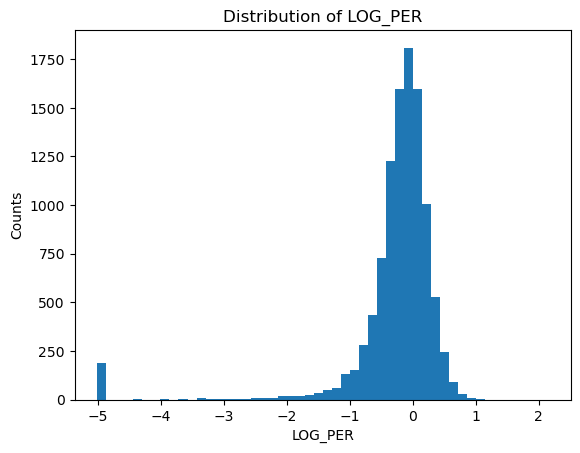

In [77]:
plt.hist(df["LOG_PER"].to_numpy(), bins=50);
plt.title("Distribution of LOG_PER")
plt.xlabel("LOG_PER")
plt.ylabel("Counts")

In [78]:
#grab all columns as a list
all_columns = list(df.columns)

#grab just the numerical features (drop NAME, PLAYER_ID, POS)
features = [all_columns[2]] + all_columns[4:6] + all_columns[7:]

print(features)

['SEASON_START', 'PLAYER_AGE', 'EXPERIENCE', 'GP', 'GS', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'PER', 'TS_PERCENT', 'X3P_AR', 'F_TR', 'ORB_PERCENT', 'DRB_PERCENT', 'TRB_PERCENT', 'AST_PERCENT', 'STL_PERCENT', 'BLK_PERCENT', 'TOV_PERCENT', 'USG_PERCENT', 'OWS', 'DWS', 'WS', 'WS_48', 'OBPM', 'DBPM', 'BPM', 'VORP', 'Salary', 'Percent_team_salary', 'WAIVED_OFF', 'WAIVED_REG', 'WAIVED_POST', 'RELEASED_OFF', 'RELEASED_REG', 'RELEASED_POST', 'TRADED_OFF', 'TRADED_REG', 'TRADED_POST', 'WAIVED_NEXT_OFF', 'WAIVED_NEXT_REG', 'WAIVED_NEXT_POST', 'RELEASED_NEXT_OFF', 'RELEASED_NEXT_REG', 'RELEASED_NEXT_POST', 'TRADED_NEXT_OFF', 'TRADED_NEXT_REG', 'TRADED_NEXT_POST', 'WAIVED_NEXT_NEXT_OFF', 'RELEASED_NEXT_NEXT_OFF', 'TRADED_NEXT_NEXT_OFF', 'WAIVED_NBA_YEAR', 'WAIVED_NEXT_NBA_YEAR', 'RELEASED_NBA_YEAR', 'RELEASED_NEXT_NBA_YEAR', 'TRADED_NBA_YEAR', 'TRADED_NEXT_NBA_YEAR', 'IN_LEAGUE_NEXT', 'WEIG

## Compute correlations

In [79]:
corr = df[features].corr()

In [80]:
abs(corr["IN_LEAGUE_NEXT"]).sort_values(ascending=False)

IN_LEAGUE_NEXT            1.000000
GP                        0.465623
WAIVED_NBA_YEAR           0.461538
MIN                       0.422038
PF                        0.416180
FGA                       0.361529
WAIVED_REG                0.361419
FGM                       0.360512
PTS                       0.356457
TOV                       0.349256
STL                       0.345727
DREB                      0.344715
REB                       0.339088
PF_PER_GAME               0.337646
DWS                       0.335942
LOG_PER                   0.333628
PTS_PER_GAME              0.331905
WS                        0.324099
GS                        0.312601
WAIVED_NEXT_OFF           0.310629
OBPM                      0.307792
FTA                       0.306263
BPM                       0.301925
DREB_PER_GAME             0.301365
FTM                       0.298467
STARTS_PER_GP             0.297257
STL_PER_GAME              0.296169
REB_PER_GAME              0.293180
TOV_PER_GAME        

In [81]:
#Note that ~84% of players have IN_LEAGUE_NEXT = 1, so we have imbalanced classes 
print(df.IN_LEAGUE_NEXT.value_counts(normalize=False), '\n')
print(df.IN_LEAGUE_NEXT.value_counts(normalize=True))

IN_LEAGUE_NEXT
1.0    8704
0.0    1644
Name: count, dtype: int64 

IN_LEAGUE_NEXT
1.0    0.841129
0.0    0.158871
Name: proportion, dtype: float64


# Training a simple classifier

We can see that `IN_LEAGUE_NEXT` is potentially a good response variable for two reasons:
- it has reasonably high correlations with the predictor data (with, e.g., `GP`, `PF`, `PCT_TEAM_SALARY`)
- it describes the future state of a player, so predicting it using just current-season stats data is interesting.

Predicting whether or not a player is in the league next year is also reasonably interesting, and training an interpretable model (like the logistic regression model below) can give us some hints as to what fringe NBA players could do to increase their odds of staying in the league.

In [82]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, train_test_split

In [83]:
#let's be careful here: some of the columns in the dataframe include future data.  Let's just use
#current-season stats and salary data
predictors = features[0:46] + features[74:]

print(predictors)

['SEASON_START', 'PLAYER_AGE', 'EXPERIENCE', 'GP', 'GS', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'PER', 'TS_PERCENT', 'X3P_AR', 'F_TR', 'ORB_PERCENT', 'DRB_PERCENT', 'TRB_PERCENT', 'AST_PERCENT', 'STL_PERCENT', 'BLK_PERCENT', 'TOV_PERCENT', 'USG_PERCENT', 'OWS', 'DWS', 'WS', 'WS_48', 'OBPM', 'DBPM', 'BPM', 'VORP', 'Salary', 'Percent_team_salary', 'WEIGHT', 'HEIGHT_INCHES', 'GREATEST_75', 'INV_PICK', 'OREB_PER_GAME', 'DREB_PER_GAME', 'REB_PER_GAME', 'AST_PER_GAME', 'STL_PER_GAME', 'BLK_PER_GAME', 'TOV_PER_GAME', 'PF_PER_GAME', 'PTS_PER_GAME', 'OREB_PER_MIN', 'DREB_PER_MIN', 'REB_PER_MIN', 'AST_PER_MIN', 'STL_PER_MIN', 'BLK_PER_MIN', 'TOV_PER_MIN', 'PF_PER_MIN', 'PTS_PER_MIN', 'STARTS_PER_GP', 'LOG_PER']


In [84]:
#make train-test split
X_train, X_test, y_train, y_test = train_test_split(df[predictors], df.IN_LEAGUE_NEXT, 
                                                    test_size=0.1, random_state=815, shuffle=True, stratify=df.IN_LEAGUE_NEXT.values)

In [85]:
#oversample the rare class (waived players)
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN, SMOTETomek


#it seems like SMOTE (generating synthetic data for players with IN_LEAGUE_NEXT=0) works better than
#randomly oversampling, randomly undersampling, and combined methods (SMOTEENN, SMOTETomek)
smote = SMOTE(random_state=5)
X_train_re, y_train_re = smote.fit_resample(X_train, y_train)

#ros = RandomOverSampler(random_state=5)
#X_train_re, y_train_re = ros.fit_resample(X_train, y_train)

#rus = RandomUnderSampler(random_state=5)
#X_train_re, y_train_re = rus.fit_resample(X_train, y_train)

#smoteenn = SMOTEENN(random_state=5)
#X_train_re, y_train_re = smoteenn.fit_resample(X_train, y_train)

#smotetomek = SMOTETomek(random_state=5)
#X_train_re, y_train_re = smotetomek.fit_resample(X_train, y_train)

Accuracy:    0.86
Precision:   0.93
Recall:      0.90
NPV:         0.56
Specificity: 0.66


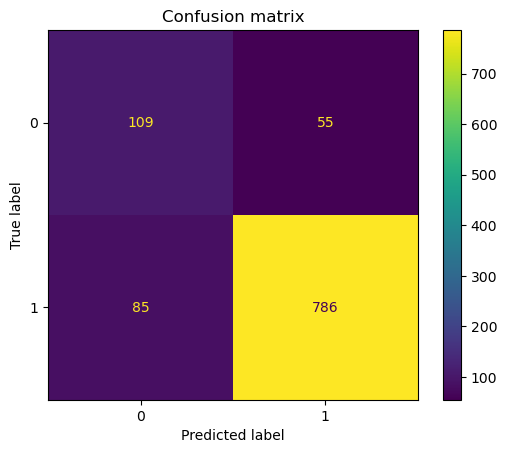

In [86]:
lr = Pipeline([("scale", StandardScaler()), ("log_reg", LogisticRegression(penalty=None, max_iter=10_000))])
lr.fit(X_train_re, y_train_re)
preds    = lr.predict(X_test)

accuracy  = accuracy_score(y_test, preds)
conf      = confusion_matrix(y_test, preds)
#grab true negatives, true positives, false positives, false negatives
tn = conf[0,0]
tp = conf[1,1]
fp = conf[0,1]
fn = conf[1,0]

#precision (positive predictive value): what % of players classified as 1's are true 1's?
precision   = tp/(tp+fp)
#recall (sensitivity): what % of true 1's are classified as 1?
recall      = tp/(tp+fn)
#negative predictive value (NPV): what % of players classified as 0's are true 0's?
npv         = tn/(tn+fn)
#specificity: what % of true 0's are classified as 0?
specificity = tn/(tn+fp)

print(f"Accuracy:    {accuracy:.2f}")
print(f"Precision:   {precision:.2f}")
print(f"Recall:      {recall:.2f}")
print(f"NPV:         {npv:.2f}")
print(f"Specificity: {specificity:.2f}")

ConfusionMatrixDisplay(conf).plot()
plt.title("Confusion matrix")
plt.show()

To briefly summarize: the performance is reasonably good.  The classifier is really good ($\sim 90\%$ precision and recall) at correctly guessing when a player will stay in the league (which is the majority class, about $84\%$ of all rows), and slightly better than random chance when a player is going to be out of the league ($\sim 60\%$ recall and NPV).

Note that we only used stats and salary data!  We could also include predictors like draft position if a player was drafted and whether or not a player has been previously traded or waived.  To see which additional predictors could be useful, we need to **look at the false positives and false negatives** to see why our model is guessing wrong.

## Investigating misclassified rows

Let's add a column to `df` with the model's prediction, `MODEL_PRED`.  Then we can consider false positives and false negatives, and see why they get misclassified.

In [87]:
df["MODEL_PRED"] = lr.predict(df[predictors])

### Inspecting false positives

Let's now look at false positives: players the model think should be in the NBA next season, who don't end up playing.

In [88]:
df.loc[ (df["IN_LEAGUE_NEXT"]==0) & (df["MODEL_PRED"]==1) ].sample(5, random_state=815)[["NAME"] + predictors]

,NAME,SEASON_START,PLAYER_AGE,EXPERIENCE,GP,GS,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PER,TS_PERCENT,X3P_AR,F_TR,ORB_PERCENT,DRB_PERCENT,TRB_PERCENT,AST_PERCENT,STL_PERCENT,BLK_PERCENT,TOV_PERCENT,USG_PERCENT,OWS,DWS,WS,WS_48,OBPM,DBPM,BPM,VORP,Salary,Percent_team_salary,WEIGHT,HEIGHT_INCHES,GREATEST_75,INV_PICK,OREB_PER_GAME,DREB_PER_GAME,REB_PER_GAME,AST_PER_GAME,STL_PER_GAME,BLK_PER_GAME,TOV_PER_GAME,PF_PER_GAME,PTS_PER_GAME,OREB_PER_MIN,DREB_PER_MIN,REB_PER_MIN,AST_PER_MIN,STL_PER_MIN,BLK_PER_MIN,TOV_PER_MIN,PF_PER_MIN,PTS_PER_MIN,STARTS_PER_GP,LOG_PER
4688,Victor Alexander,1994,25.0,4,50,29.0,1237.0,230,447,0.515,6.0,25.0,0.240,36,60,0.600,87.0,204.0,291.0,60,28.0,29.0,76.0,145,502,12.8,0.530,0.056,0.134,7.7,18.4,13.0,7.8,1.1,1.6,13.8,18.8,0.3,0.8,1.1,0.044,-2.2,-0.7,-2.9,-0.3,1377500.0,0.069580,265.0,82,0,0.058824,1.740000,4.080000,5.820000,1.200000,0.560000,0.580000,1.520000,2.900000,10.040000,0.070331,0.164915,0.235247,0.048504,0.022635,0.023444,0.061439,0.117219,0.405821,0.580000,-0.158605
4288,Khalid El-Amin,2000,22.0,1,50,14.0,935.0,115,311,0.370,28.0,84.0,0.333,56,72,0.778,21.0,60.0,81.0,145,48.0,2.0,54.0,99,314,12.2,0.458,0.270,0.232,2.6,7.9,5.1,27.5,2.8,0.2,13.6,19.7,0.2,0.4,0.6,0.030,-1.7,-0.7,-2.4,-0.1,316969.0,0.010675,200.0,70,0,0.029412,0.420000,1.200000,1.620000,2.900000,0.960000,0.040000,1.080000,1.980000,6.280000,0.022460,0.064171,0.086631,0.155080,0.051337,0.002139,0.057754,0.105882,0.335829,0.280000,-0.206614
7861,Manny Harris,2011,22.0,2,26,5.0,456.0,60,150,0.400,12.0,36.0,0.333,41,59,0.695,11.0,59.0,70.0,31,13.0,6.0,27.0,28,173,11.7,0.492,0.240,0.393,2.6,15.3,8.7,11.8,1.5,1.0,13.3,20.0,0.1,0.2,0.3,0.030,-1.4,-0.9,-2.3,0.0,122942.0,0.001895,185.0,77,0,0.000000,0.423077,2.269231,2.692308,1.192308,0.500000,0.230769,1.038462,1.076923,6.653846,0.024123,0.129386,0.153509,0.067982,0.028509,0.013158,0.059211,0.061404,0.379386,0.192308,-0.248461
6203,Robert Whaley,2005,24.0,1,23,0.0,212.0,23,57,0.404,0.0,0.0,0.000,3,6,0.500,16.0,27.0,43.0,17,7.0,8.0,14.0,41,49,7.6,0.411,0.000,0.105,9.1,15.6,12.3,13.8,1.8,3.1,19.0,16.1,-0.2,0.3,0.0,0.004,-5.6,0.5,-5.1,-0.2,398762.0,0.006950,260.0,82,0,0.019608,0.695652,1.173913,1.869565,0.739130,0.304348,0.347826,0.608696,1.782609,2.130435,0.075472,0.127358,0.202830,0.080189,0.033019,0.037736,0.066038,0.193396,0.231132,0.000000,-0.679902
7417,Rodrigue Beaubois,2012,25.0,4,45,0.0,549.0,65,176,0.369,21.0,72.0,0.292,30,38,0.789,9.0,48.0,57.0,84,19.0,4.0,33.0,54,181,10.6,0.470,0.409,0.216,1.9,9.6,5.8,22.6,1.8,0.6,14.6,18.7,0.0,0.4,0.4,0.032,-2.3,-0.3,-2.6,-0.1,2227332.0,0.031925,185.0,74,0,0.040000,0.200000,1.066667,1.266667,1.866667,0.422222,0.088889,0.733333,1.200000,4.022222,0.016393,0.087432,0.103825,0.153005,0.034608,0.007286,0.060109,0.098361,0.329690,0.000000,-0.347196


Let's go case-by-case:
- Wilkins was still productive in the 1994 season.  He got poached by a Greek Euroleague team who wanted "the best player worldwide right now"... and ended up with Wilkins.
- AK47 was productive in 2010, but decided to go to Russia for the next season.  He played one more season in the NBA after that.
- Morris was still a decent big at this point.  Went to China after this season.
- Christopher played the next couple seasons in the G-League before returning to the NBA in 2024.
- Lance Stephenson went to China in the next season, but made an NBA return and played another 2 seasons in 2021 and 2022.

Conclusions:
- These are all very reasonable misclassifications.  It might be very hard to decrease the number of false positives if they're all like this.

### Inspecting false negatives

Let's now look at false negatives: players the model thinks should be out of the league, who manage to hang on.

In [89]:
df.loc[ (df["IN_LEAGUE_NEXT"]==1) & (df["MODEL_PRED"]==0) ].sample(5, random_state=815)[["NAME"] + predictors]

,NAME,SEASON_START,PLAYER_AGE,EXPERIENCE,GP,GS,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PER,TS_PERCENT,X3P_AR,F_TR,ORB_PERCENT,DRB_PERCENT,TRB_PERCENT,AST_PERCENT,STL_PERCENT,BLK_PERCENT,TOV_PERCENT,USG_PERCENT,OWS,DWS,WS,WS_48,OBPM,DBPM,BPM,VORP,Salary,Percent_team_salary,WEIGHT,HEIGHT_INCHES,GREATEST_75,INV_PICK,OREB_PER_GAME,DREB_PER_GAME,REB_PER_GAME,AST_PER_GAME,STL_PER_GAME,BLK_PER_GAME,TOV_PER_GAME,PF_PER_GAME,PTS_PER_GAME,OREB_PER_MIN,DREB_PER_MIN,REB_PER_MIN,AST_PER_MIN,STL_PER_MIN,BLK_PER_MIN,TOV_PER_MIN,PF_PER_MIN,PTS_PER_MIN,STARTS_PER_GP,LOG_PER
9830,Mychal Mulder,2019,26.0,1,7,3.0,204.0,26,67,0.388,16.0,52.0,0.308,9,12,0.750,3.0,20.0,23.0,8,2.0,1.0,5.0,20,77,7.8,0.533,0.776,0.179,1.5,11.0,6.1,5.8,0.5,0.4,6.5,16.2,0.0,0.0,0.1,0.017,-3.2,-2.9,-6.0,-0.2,187782.0,0.001453,195.0,75,0,0.000000,0.428571,2.857143,3.285714,1.142857,0.285714,0.142857,0.714286,2.857143,11.000000,0.014706,0.098039,0.112745,0.039216,0.009804,0.004902,0.024510,0.098039,0.377451,0.428571,-0.653926
10076,Chris Chiozza,2018,23.0,1,7,0.0,33.0,2,8,0.250,2.0,5.0,0.400,0,0,0.000,1.0,3.0,4.0,4,1.0,1.0,1.0,2,6,7.0,0.375,0.625,0.000,3.3,10.3,6.7,16.1,1.5,2.6,11.1,11.8,0.0,0.0,0.0,0.023,-2.7,1.4,-1.3,0.0,137374.0,0.001086,175.0,71,0,0.000000,0.142857,0.428571,0.571429,0.571429,0.142857,0.142857,0.142857,0.285714,0.857143,0.030303,0.090909,0.121212,0.121212,0.030303,0.030303,0.030303,0.060606,0.181818,0.000000,-0.762140
10005,Carsen Edwards,2020,23.0,2,31,1.0,276.0,47,111,0.423,18.0,63.0,0.286,11,13,0.846,3.0,23.0,26.0,14,7.0,1.0,7.0,25,123,10.2,0.527,0.568,0.117,1.2,9.4,5.2,7.4,1.2,0.3,5.7,19.3,0.1,0.2,0.3,0.051,-3.2,-1.3,-4.5,-0.2,1517981.0,0.011419,200.0,71,0,0.030303,0.096774,0.741935,0.838710,0.451613,0.225806,0.032258,0.225806,0.806452,3.967742,0.010870,0.083333,0.094203,0.050725,0.025362,0.003623,0.025362,0.090580,0.445652,0.032258,-0.385662
4116,DerMarr Johnson,2006,27.0,6,39,7.0,419.0,50,154,0.325,19.0,88.0,0.216,16,21,0.762,10.0,47.0,57.0,17,16.0,12.0,27.0,39,135,6.1,0.414,0.571,0.136,2.7,12.5,7.7,6.0,1.9,2.1,14.2,19.5,-0.7,0.5,-0.3,-0.032,-4.6,0.3,-4.3,-0.2,865063.0,0.013203,210.0,81,0,0.166667,0.256410,1.205128,1.461538,0.435897,0.410256,0.307692,0.692308,1.000000,3.461538,0.023866,0.112172,0.136038,0.040573,0.038186,0.028640,0.064439,0.093079,0.322196,0.179487,-0.899761
10035,Kelan Martin,2020,25.0,2,35,0.0,323.0,62,138,0.449,24.0,60.0,0.400,9,10,0.900,18.0,60.0,78.0,17,10.0,10.0,16.0,35,157,13.9,0.551,0.435,0.072,6.1,20.1,13.1,7.5,1.5,2.5,10.1,20.9,0.1,0.4,0.4,0.066,-1.1,-1.3,-2.4,0.0,1445697.0,0.011101,230.0,77,0,0.000000,0.514286,1.714286,2.228571,0.485714,0.285714,0.285714,0.457143,1.000000,4.485714,0.055728,0.185759,0.241486,0.052632,0.030960,0.030960,0.049536,0.108359,0.486068,0.000000,-0.076161


Case-by-case:
- Landry was not _that bad_ in 2013, and played 3 more seasons in the NBA before going overseas.
- Pondexter had an awful FG_PCT and didn't play much in 2017.  Somehow he played 2 more seasons before becoming a coach.
- Jones was young and had potential, but played the next year in the G-League.  He played multiple years in the NBA after this season.
- Lister